# Facebook: Paid vs Unpaid Posts

### Introduction
**Background** 

We are in the digital era, and Facebook is one of the biggest social media platforms known to society. Hence, it is a great platform for different businesses to reach consumers globally. With this idea in mind, we believe it would be beneficial for businesses to know if they should pay for a post to achieve a certain number of post total reach, post engagements, and page likes, or if it is better to follow the organic route (free content). This is significant for designing marketing strategies, especially for small businesses or start-ups with limited funds.

**Question** 

Can we use the amount of lifetime post total reach along with lifetime page likes and post engagements to predict whether a future post is paid or unpaid?

**Dataset** 

The dataset (https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip) we used to answer this question consists of data from 500 Facebook posts of a renowned cosmetic brand in 2014.  This data was downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Facebook+metrics). 

Each observation in the dataset shows the type of post (paid vs unpaid) as well as post performance metrics, from the number of likes and shares to total impressions. According to the paper the dataset is based on, most of the information was exported directly from the company's Facebook page (Moro et al., 2016).

### Methods and Results
To run the following analysis in Jupyter notebook, select the Run All Cells option from Run.

##### Step 1: Loading packages
We started by loading all the necessary packages to perform our data analysis using the `library` function.

In [1]:
# load packages
library(repr)
library(tidyverse)
library(tidymodels)

# set plot options and set max number of rows to display
options(repr.plot.width = 9, repr.plot.height = 9)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Variable Description** 

The columns in the dataset that are relevant in our analysis are:

- `Lifetime_Post_Reach`: The number of unique users who saw a page post (regardless of whether they've engaged with it)
- `Lifetime_Like_Engage`: The number of unique users who have liked a page and clicked anywhere in a post
- `Paid`: Whether the post is paid (1) or unpaid (0)

(Note: The column names have been appropriately renamed in our analysis for conciseness)

We use `Lifetime_Post_Reach` as a predictor because it is a measure of how much exposure a post achieves (Moro et al., 2016). In this case, "unique users" mean that an individual who owns multiple accounts is only considered as one user. We also use `Lifetime_Like_Engage` as a predictor because it is said to be a stronger measure for user feedback, since it measures individual interactions with the content (Moro et al., 2016). Therefore, we focus on these two predictors for our classifier to predict the target variable (`Paid`).

##### Step 2: Loading and cleaning data
The [data](https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip) was downloaded from the web and read into R using `read.delim`. We need to treat `Paid` as a categorical variable instead of a numerical variable in order to classify our observations, so we converted it into a factor with the `as_factor` function. Moreover, we selected the relevant columns for our analysis as described above using the `select` function.

In [2]:
# set seed to make analysis reproducible
set.seed(3060) 

# load data
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip", temp, mode = "wb")
unzip(temp, "dataset_Facebook.csv")
facebook_unscaled <- read.delim("dataset_Facebook.csv", sep = ";") %>% 
    mutate(Paid = as_factor(Paid)) %>% 
    select(Paid,
           Lifetime_Post_Reach = Lifetime.Post.Total.Reach,
           Lifetime_Like_Engage = Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post)

The `filter` function was used to remove `NA` values under the `Paid` column, as these observations are irrelevant to our analysis. The dataset was then scaled and centered using the `scale` function to ensure that all variables will be on a comparable scale.

In [3]:
# scale and center data
facebook <- facebook_unscaled %>%
    filter(!is.na(Paid)) %>% # remove rows where Paid is NA
    mutate(Lifetime_Post_Reach = scale(Lifetime_Post_Reach, center = TRUE),
           Lifetime_Like_Engage = scale(Lifetime_Like_Engage, center = TRUE))
facebook

Paid,Lifetime_Post_Reach,Lifetime_Like_Engage
<fct>,"<dbl[,1]>","<dbl[,1]>"
0,-0.4908219,-0.8016572
0,-0.1521492,0.8111968
0,-0.5057168,-0.7804569
⋮,⋮,⋮
0,-0.4588352,-0.5048529
0,-0.4457417,-0.4037438
0,-0.4291332,-0.3923282


**Table 1: Standardized Facebook dataset**

##### Step 3: Splitting the data into training and testing sets
The data was then split into a training and testing set using the `initial_split` function, wherein the training set consists of 75% of the original data (`prop = 0.75`) and the testing set consists of the remaining 25%. We set the `strata` argument to `Paid` as this variable is our class label.

We chose a 75%/25% train/test split as this was deemed to be a good starting point for training an accurate model. The training set is used to build and tune our K-nearest neighbours (k-nn) classifier while the testing set is used to evaluate the accuracy of our classifier. 

In [4]:
# split the data into a training and testing dataset
facebook_split <- initial_split(facebook, prop = 0.75, strata = Paid) 
facebook_train <- training(facebook_split)   
facebook_test <- testing(facebook_split)

##### Step 4: Exploring our data
Using only the training data, we summarized the data in a table with the `group_by` and `summarize` functions to observe how the observations in each class are split among the data. We grouped the data by class (`Paid`) and used the `n` function within `summarize` to count the number of observations in each group.

In [5]:
# summarize training data
facebook_summary <- facebook_train %>% 
    group_by(Paid) %>% 
    summarize(
        n = n(),
        percentage = n() / nrow(facebook_train) * 100
    )
facebook_summary

`summarise()` ungrouping output (override with `.groups` argument)



Paid,n,percentage
<fct>,<int>,<dbl>
0,270,72
1,105,28


**Table 2: Summary of training data**

Table 2 reports the number and percentage of unpaid (0) and paid (1) observations in our training dataset. There are 270 (72%) unpaid observations and 105 (28%) paid observations. 

Using only the training data, we created a visualization to explore the relationship between the predictor variables and the target variable. We created a plot with `Lifetime_Post_Reach` on the x-axis and `Lifetime_Like_Engage` on the y-axis, and coloured points by the type of post (`Paid`).

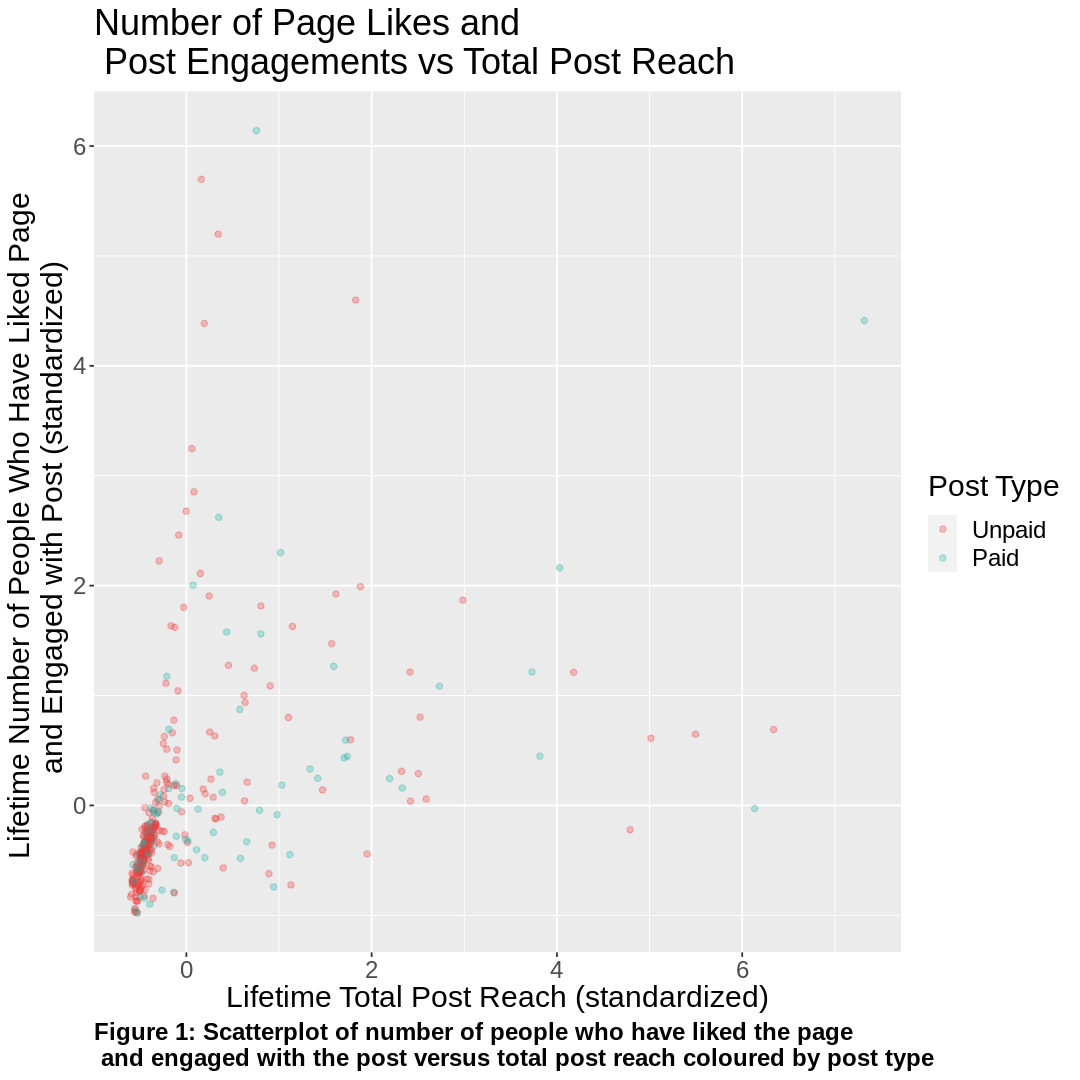

In [6]:
# create scatterplot to explore relationship between predictors and target variable
facebook_plot <- facebook_train %>%
    ggplot(aes(x = Lifetime_Post_Reach, y = Lifetime_Like_Engage, colour = Paid)) +
    geom_point(alpha = 0.3) +  # adjust transparency of points for easier visualization
    labs(x = "Lifetime Total Post Reach (standardized)",
         y = "Lifetime Number of People Who Have Liked Page \n and Engaged with Post (standardized)",
         color = "Post Type",
         title = "Number of Page Likes and \n Post Engagements vs Total Post Reach",
         caption = "Figure 1: Scatterplot of number of people who have liked the page \n and engaged with the post versus total post reach coloured by post type") +
    scale_color_manual(labels = c("Unpaid", "Paid"), values = c("brown2", "lightseagreen")) +
    theme(text = element_text(size = 18), plot.caption = element_text(face = "bold", hjust = 0))
facebook_plot

Figure 1 shows that the predictor variables have a positive relationship. Some unpaid posts tend to have lower post reach and lower engagements/likes, but overall the points appear quite scattered and overlap each other which makes it difficult to differentiate between paid and unpaid posts based on the plot alone.

##### Step 5: Tuning the classifier

- We first created a recipe, specifying `Paid` as the target and the variables `Lifetime_Post_Reach` and `Liketime_Like_Engage` as predictors. Since the k-nn algorithm is sensitive to the scale of variables, it is important to include preprocessing steps in the recipe to scale and center all the predictors, using the `step_scale()` and `step_center()` functions.
- Since we want to tune the model, we created a model specification using the `nearest_neighbor()` function with the`neighbors` argument set to `tune()`.
- Cross validation can help us choose the optimal $k$ value, so we split the training data into 5 folds for cross-validation with the `vfold_cv()` function. In cross-validation, we have to consider the size of the data and the speed of both the algorithm and the computer. Thus, 5-folds is typically a good number to proceed with.
- We combined the recipe and model specification into a `workflow()` analysis and used the `tune_grid` function to fit the model for a range of values. We set the `grid` argument of `tune_grid` to a tibble we created with a `neighbors` variable containing each value from $k = 1$ to $k = 20$ using the `seq` function.
- Finally, we aggregate the mean and standard error of the classifier's validation accuracy across the folds using the `collect_metrics` function.

In [7]:
# create recipe with preprocessing steps for all variables
facebook_recipe <- recipe(Paid ~ Lifetime_Post_Reach + Lifetime_Like_Engage, data = facebook_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# create nearest neighbor model specification
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

# split up training data into 5 folds for cross validation
facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = Paid)

# create tibble containing a sequence of k values to try in tuning 
k_vals <- tibble(neighbors = seq(1, 20))

# combine recipe and model specification in workflow analysis
knn_results <- workflow() %>%
    add_recipe(facebook_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = facebook_vfold, grid = k_vals) %>%
    collect_metrics()

##### Step 6: Choosing the best number of neighbours, $k$
Because we only care about accuracy, we filtered for `accuracy` under the `.metric` column using the `filter` function. We then created a plot with `neighbors` on the x-axis and `mean` (the estimated accuracy) on the y-axis to help us choose the best $k$.

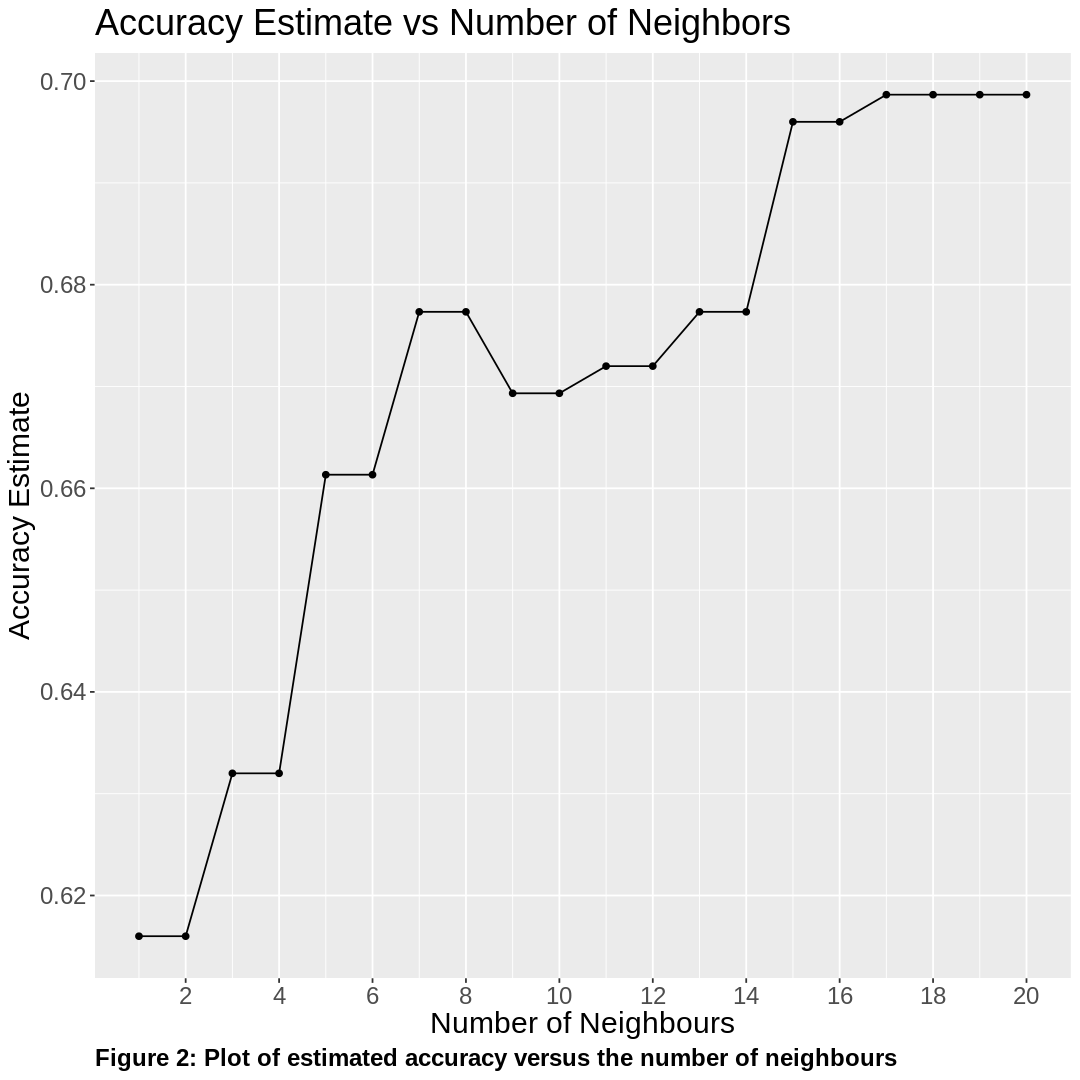

In [8]:
# filter results for accuracy metric only
accuracies <- knn_results %>% 
    filter(.metric == 'accuracy')

# plot accuracy versus k to choose optimal value of k
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbours", y = "Accuracy Estimate", caption = "Figure 2: Plot of estimated accuracy versus the number of neighbours") +
    ggtitle("Accuracy Estimate vs Number of Neighbors") +
    scale_x_continuous(breaks = seq(0, 20, 2)) +
    theme(text = element_text(size = 18), plot.caption = element_text(face = "bold", hjust = 0))
accuracy_versus_k

Figure 2 suggests that $k = 17$, $18$, $19$, or $20$ yields the highest accuracy estimate of ~ 70%. Since we can only pick one $k$, we selected $k = 19$ because this value not only provides the highest accuracy estimate but is also reliable in the presence of uncertainty as changing $k$ to a nearby value does not decrease accuracy. Moreover, $k = 19$ does not make the computational cost of training the model prohibitive and is an odd number which prevents ties in k-nn.

##### Step 7: Building the final classifier using chosen $k$
To build our final model, we first created a new model specification with the chosen $k$. We then retrained the classifier by combining the recipe (reused `facebook_recipe`) and model specification into a workflow, and finally using the `fit` function with the training data.

In [9]:
# create new model specification with chosen k value 
best_k <- 19
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) %>%
    set_engine('kknn') %>%
    set_mode('classification')

# retrain the classifier
facebook_fit <- workflow() %>%
    add_recipe(facebook_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = facebook_train)

##### Step 8: Predicting on test data and assessing prediction quality
To evaluate the performance of our k-nn classifier, we used our model to predict on the testing dataset using the `predict` function and added the predictions to the original test data using `bind_cols`. We used the `metrics` function to obtain the accuracy, setting the `truth` argument to the column with the true values (`Paid`) and the `estimate` argument to the column of predictions (`.pred_class`). 

In [10]:
# use fitted model to predict on held-out data (testing set)
facebook_test_predictions <- predict(facebook_fit, facebook_test) %>%
    bind_cols(facebook_test)

# compute prediction accuracy for classifier
facebook_metrics <- facebook_test_predictions %>%
    metrics(truth = Paid, estimate = .pred_class)
facebook_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7338710
kap,binary,0.1330508


**Table 3: Classifier's prediction accuracy on testing dataset**

Table 3 shows the statistics about the quality of our model. The `accuracy` row shows that the estimated accuracy of the classifier on the testing data is 73.4%.

We then created a confusion matrix using the `conf_mat` function and set the `truth` and `estimate` arguments similar to the `metrics` function above. 

In [11]:
# display confusion matrix for classifier
confusion <- facebook_test_predictions %>%
    conf_mat(truth = Paid, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 86 29
         1  4  5

**Table 4: Confusion matrix**

Table 4 shows the predicted labels and correct labels. We see that our classifier predicted a total of 86 + 5 = 91 observations correctly. Our classifier also predicted 4 observations as paid when they were actually unpaid, and 29 observations as unpaid when they were paid. 

### Discussion

**Summary:**
Overall, it was found that lifetime post reach and lifetime likes/engagement are moderately weak predictors of whether a Facebook post is paid or not. Although the classifier had an accuracy of 73.4% (Table 3), the predicted trend is not reliably seen in our results. It can be noted that in Table 4, only 5 of the 34 paid posts were correctly predicted whereas 86 of the 90 unpaid posts were correctly predicted. This means that our classifier's accuracy is fairly skewed since the ratio of correct predictions is 86:5 for unpaid to paid posts; therefore, it appears that our classifier is unreliable in predicting paid posts. 

From the preliminary data analysis (Table 2), we learned that there were more unpaid posts than paid. The majority classifier would be suspected to have an accuracy of around 72% (close to majority class proportion in training data), so our classifier does not do much better than the baseline. Perhaps this explains the observed accuracy because the performance of the k-nn algorithm can be affected by imbalanced classes. Tracing back, perhaps the $k$ value for the classifier also suffers from the same problem. The $k$ value was chosen based on optimal accuracy, but that may be skewed by identifying a higher number of unpaid posts correctly.

**Expected Results:** Contrary to our hypothesis, a higher lifetime post reach and higher lifetime likes and engagement did not reliably correlate to a paid post. This finding seemingly replicates the findings of another [study](https://www.sciencedirect.com/science/article/pii/S0148296316000813), where it was found that a paid post only boosted its reachability by 7% (Moro et al., 2016). Interestingly, lifetime post reach appears to be a slightly more accurate predictor, compared to the page/post engagement predictor. 

**Impact of Findings:** Our classifier's accuracy is about 70%, this means that about 30% of the time our classifier makes a mistake. Based on our findings, there is room for improvement before we would use this classifier to predict whether a post is paid or not. For instance, we might want to include more data to improve our classifier accuracy, specifically paid post examples as this is where our classifier mispredicted the most. We might also consider resampling the data to reduce class imbalance.

Perhaps we could also improve the classifier accuracy by including other predictors as there were paid posts with low reach, low engagement, and low page likes; hence, this suggests that there may be other factors involved in determining the type of post. A [study](https://www.tandfonline.com/doi/abs/10.1080/10641734.2018.1503113?journalCode=ujci20) found that many different factors may affect post likes and engagement (Quesenberry & Coolsen, 2018). For example, post content and even when the post was created have significant effects on how many likes/engagements the post achieves. Thus, these other factors should be examined in future studies to determine how they may act as moderating factors. 

In terms of application, companies can use this information, combined with actual purchasing data, to streamline their advertising strategies. Specifically, paying for a particular type of post in a specific month may help increase post reach, which would increase potential consumer exposure and may in turn increase purchases.

**Future Questions:**
Why do some paid posts have low total reach and low engagement/page likes? What other factors should companies consider when paying for social media posts? Is paid social media necessarily better and faster than organic social media for achieving business goals, or is a combination of both the best for marketing?

### References

Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, 69(9), 3341-3351. doi:10.1016/j.jbusres.2016.02.010


Quesenberry, K. A., & Coolsen, M. K. (2018). What Makes Facebook Brand Posts Engaging? A Content Analysis of Facebook Brand Post Text That Increases Shares, Likes, and Comments to Influence Organic Viral Reach. Journal of Current Issues & Research in Advertising, 40(3), 229-244. doi:10.1080/10641734.2018.1503113

